In [1]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [3]:
# load data
train = pd.read_csv("./data/sign_mnist_train/sign_mnist_train.csv")
test = pd.read_csv("./data/sign_mnist_test/sign_mnist_test.csv")

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
# check if there is null in data
train.isna().sum()
test.isna().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of       label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0     False   False   False   False   False   False   False   False   False   
1     False   False   False   False   False   False   False   False   False   
2     False   False   False   False   False   False   False   False   False   
3     False   False   False   False   False   False   False   False   False   
4     False   False   False   False   False   False   False   False   False   
...     ...     ...     ...     ...     ...     ...     ...     ...     ...   
7167  False   False   False   False   False   False   False   False   False   
7168  False   False   False   False   False   False   False   False   False   
7169  False   False   False   False   False   False   False   False   False   
7170  False   False   False   False   False   False   False   False   False   
7171  False   False   False   False   False   False   False   False  

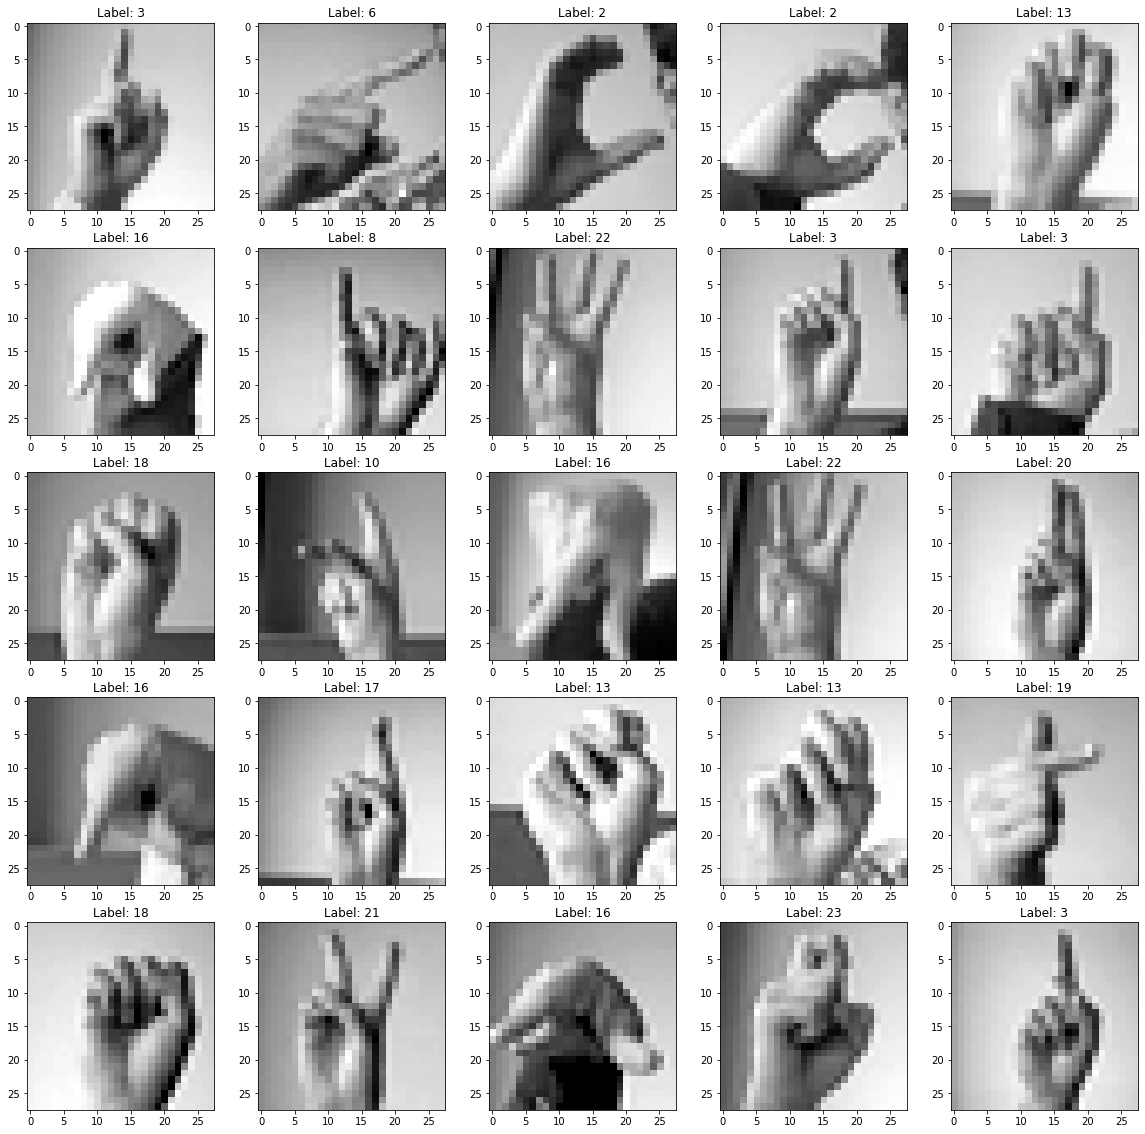

In [6]:
# visualization
# figure size
plt.figure(figsize=(20, 20))
#subplot
for i in range(25):
    img = np.array(train.iloc[i, 1:].values).reshape(28, 28)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap= 'gray')
    plt.title('Label: ' + str(train['label'][i]))
plt.show()

Text(0.5, 1.0, 'Distribution of labels in training set')

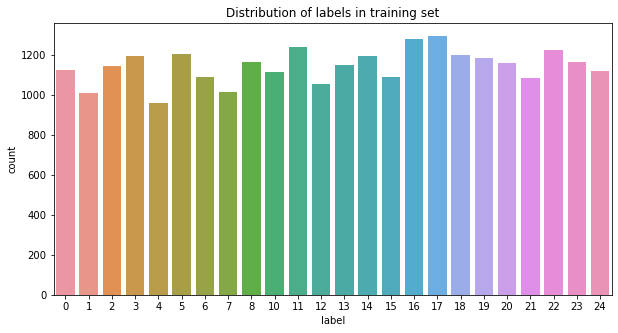

In [7]:
# label distribution
plt.figure(figsize = (10, 5))
sns.countplot(x = 'label', data = train)
plt.title('Distribution of labels in training set')

In [8]:
# get X_train
X_train = train.drop(labels = ["label"], axis = 1)
X_test = test.drop(labels = ["label"], axis = 1)

print(X_train.head())
print(X_test.head())

   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0     107     118     127     134     139     143     146     150     153   
1     155     157     156     156     156     157     156     158     158   
2     187     188     188     187     187     186     187     188     187   
3     211     211     212     212     211     210     211     210     210   
4     164     167     170     172     176     179     180     184     185   

   pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0      156  ...       207       207       207       207       206       206   
1      157  ...        69       149       128        87        94       163   
2      186  ...       202       201       200       199       198       199   
3      211  ...       235       234       233       231       230       226   
4      186  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       

In [9]:
# get Y_train
Y_train = train["label"]
Y_test = test["label"]
print(Y_train.head())
print(Y_test.head())

0     3
1     6
2     2
3     2
4    13
Name: label, dtype: int64
0     6
1     5
2    10
3     0
4     3
Name: label, dtype: int64


In [10]:
# reshape the training data
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [11]:
# Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

In [12]:
# binarization of labels
label_binarizer = LabelBinarizer()
Y_train = label_binarizer.fit_transform(Y_train)
Y_test = label_binarizer.fit_transform(Y_test)
print(Y_train)
print(Y_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [13]:
# split test set and validation set
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(21964, 28, 28, 1)
(5491, 28, 28, 1)
(21964, 24)
(5491, 24)
(7172, 28, 28, 1)
(7172, 24)


In [ ]:
!pip3 uninstall tensorflow
#import tensorflow as tf
# data augmentation
#generator = 

In [ ]:
import keras